<function matplotlib.pyplot.show>

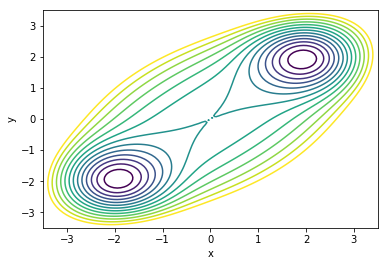

In [1]:
import numpy as np
import sys
import math
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

#FFS settings
op_type = 1              # order parameter; 1:x  2:y  3:x+y
interfaces = [-1.5, -1.4, -1.3, -1.2, -0.8, -0.5, 0.0, 1.0, 2.0]
basinA = -1.78           # boundary of basin A; must be less than first interface
basinB = interfaces[-1]  # define basin B as the final interface
interface_trajs = 1000   # number of trajectories to launch from each interface
init_coords = [-1, -1]   # initial coordinates
init_p = [0, 0]          # initial momenta
basineqlen = 5000       # basin equilibration time (in steps)
basinlen = 50000        # basin simulation time

#Langevin dynamics settings
beta = 2.5      # 1/kT
gamma = 5       # friction coefficient
dt = 0.01       # time step size

#plot potential energy surface contours
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
energy = np.zeros((N, N))
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j])
plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
plt.xlabel('x')
plt.ylabel('y')
plt.show


Flux through first interface: 0.068

Number of first crossings: 68



<function matplotlib.pyplot.show>

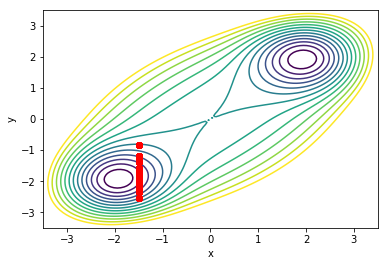

In [2]:
#declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)
#calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma)
#combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma)
#equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma)
    basintrajeq = new_basintrajeq
    op = ld.calc_op(op_type,basintrajeq[0],basintrajeq[1])
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

basintraj[0] = basintrajeq
fromBasin = False
first_crosses = []
n_cross = 0
#run basin A simulation and check for first crossings
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma)
    op = ld.calc_op(op_type,basintraj[j][0],basintraj[j][1])
    if op < basinA:
        fromBasin = True
    if fromBasin == True and op >= interfaces[0]:
        first_crosses.append(basintraj[j])
        n_cross += 1
        fromBasin = False
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

if n_cross == 0:
    sys.exit("No first crossings obtained from basin A to interface 0. Exiting...")
flux = n_cross/(basinlen*dt)
print("Flux through first interface: {}\n".format(flux))
#randomly select first crossings to launch trajectories from at the first interface, allowing duplicates
print("Number of first crossings: {}\n".format(len(first_crosses)))
configs = np.asarray(random.choices(first_crosses,k=interface_trajs))

# plot the configs selected for the first interface
plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
plt.plot(configs[:,0],configs[:,1],'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.show




Starting interface 0...
Interface 1 first crossings from 0: 514
0 to 1 crossing prob: 0.514

Starting interface 1...
Interface 2 first crossings from 1: 505
1 to 2 crossing prob: 0.505

Starting interface 2...
Interface 3 first crossings from 2: 456
2 to 3 crossing prob: 0.456

Starting interface 3...
Interface 4 first crossings from 3: 68
3 to 4 crossing prob: 0.068

Starting interface 4...
Interface 5 first crossings from 4: 317
4 to 5 crossing prob: 0.317

Starting interface 5...
Interface 6 first crossings from 5: 459
5 to 6 crossing prob: 0.459

Starting interface 6...
Interface 7 first crossings from 6: 485
6 to 7 crossing prob: 0.485

Starting interface 7...
Interface 8 first crossings from 7: 872
7 to 8 crossing prob: 0.872

Rate = 3.367963191774817e-05


<function matplotlib.pyplot.show>

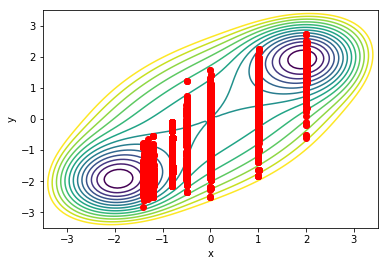

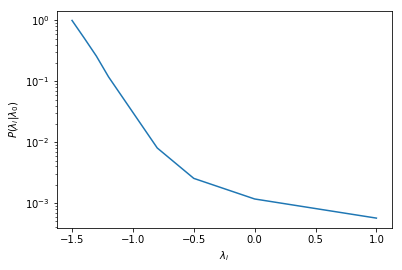

In [3]:
#run interfaces sequentially
alltrajs = []
cross_probs = []
for i in range(len(interfaces) - 1):
    inttrajs = []
    print("Starting interface {}...".format(i))
    first_crosses = []
    n_cross = 0
    for config in configs:
        op = ld.calc_op(op_type,config[0],config[1])
        step = 0
        traj = []
        traj.append(config)
        while op >= basinA and op < interfaces[i+1]:
            traj.append(ld.vv_step(traj[step],dt,beta,gamma))
            step += 1
            op = ld.calc_op(op_type,traj[step][0],traj[step][1])
        if op >= interfaces[i+1]:
            n_cross += 1
            first_crosses.append(traj[step])
        inttrajs.append(np.asarray(traj))
    if n_cross == 0:
        sys.exit("No first crossings obtained from interface {} to interface {}. Exiting...".format(i,i+1))
    cross_prob = n_cross/(len(inttrajs))
    cross_probs.append(cross_prob)
    alltrajs.append(inttrajs)
    print("Interface {} first crossings from {}: {}".format(i+1,i,len(first_crosses)))
    print("{} to {} crossing prob: {}\n".format(i,i+1,cross_prob))
    configs = np.asarray(random.choices(first_crosses,k=interface_trajs))
    plt.plot(configs[:,0],configs[:,1],'ro')

rate = flux*np.prod(np.asarray(cross_probs))
print("Rate = {}".format(rate))

surface = plt.figure(1)
plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
plt.xlabel('x')
plt.ylabel('y')

# plot cumulative crossing probability
cumuprob = []
for i in range(len(cross_probs)):
    cumuprob.append(np.prod(np.asarray(cross_probs[:i])))
probs = plt.figure(2)
plt.plot(interfaces[:-1],cumuprob)
plt.yscale('log')
plt.xlabel('$\lambda_i$')
plt.ylabel('$P(\lambda_i|\lambda_0)$')
plt.show

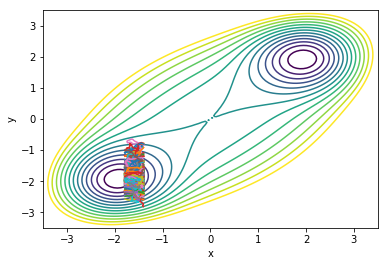

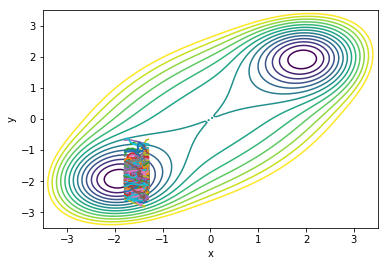

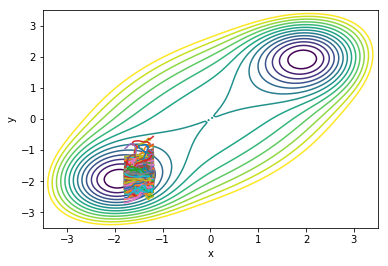

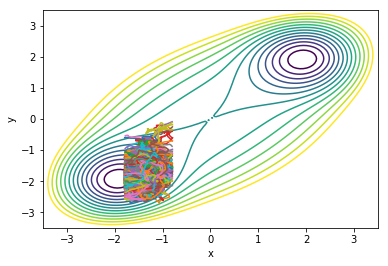

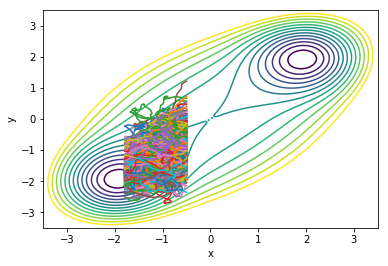

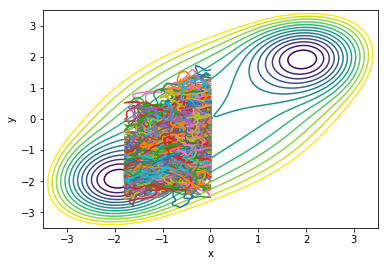

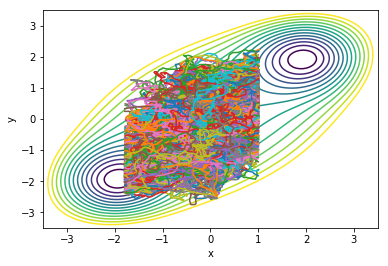

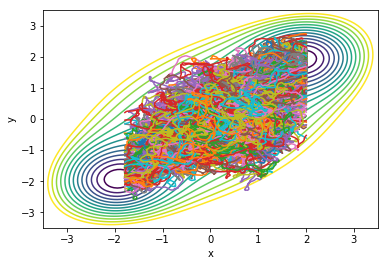

In [4]:
#plot sampled paths from each interface
for i in range(len(interfaces) - 1):
    plt.figure()
    for j in range(len(alltrajs[i])):
        plt.plot(alltrajs[i][j][:,0],alltrajs[i][j][:,1])
    plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show